In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
import ampds_preprocessing
%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/home/camilo/anaconda3/envs/nilm/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


### Exploración de la Base AMPDs v2
Se utuliza nilmtk para la carga de datos. AMPds se puede bajar desde https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIE0S4. Dentro del zip esta el archivo AMPds2.h5

In [2]:
path_h5  = 'ampds2.h5'
df = ampds_preprocessing.get_df_per_day(path_h5)

In [3]:
#df = df.rename(columns=ampds_preprocessing.FULL_NAME)

In [4]:
# divide los dataframes entre agregados y desagregados
individual = df.loc[:, df.columns.get_level_values('name')!='WHE']
aggregate = df.loc[:, df.columns.get_level_values('name')=='WHE']

In [5]:
n_days, _ = aggregate.columns.levshape
f'Se tienen {n_days} días de datos'

'Se tienen 726 días de datos'

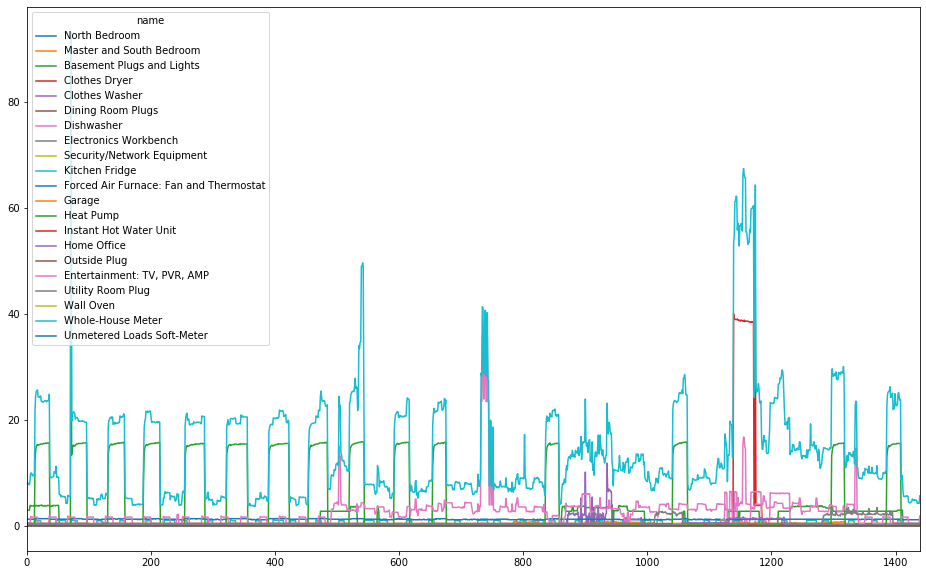

In [6]:
df[0].rename(columns=ampds_preprocessing.FULL_NAME).plot(figsize=(16,10))

In [8]:
D = individual.loc[:, 0:700].to_numpy()
D[D<0] = 0
X = aggregate.loc[:, 700:715].to_numpy()
X[X<0] = 0
np.save('X.npy', X)
np.save('D.npy', D)

In [9]:
D.shape, X.shape

((1440, 14020), (1440, 16))

Text(0, 0.5, 'corriente')

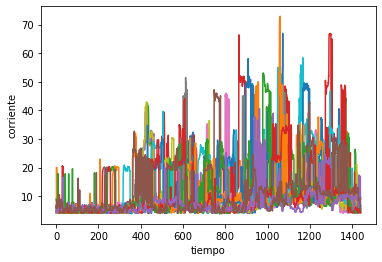

In [10]:

plt.figure()
for i in range(X.shape[1]):
    plt.plot(X[:,i])

plt.xlabel('tiempo')
plt.ylabel('corriente')

In [12]:
from fnnls import fnnls
from time import time
from scipy.optimize import nnls
#from nnls import nnls

from time import time

i = 0
t1 = time()
pro_nnls2, cost_nnls = nnls(D, X[:, i])#, max_iter=100000)
t2 = time()
print('Suma ai: ', pro_nnls2.sum())
print('Costo: ', cost_nnls)
print(f'Tiempo: {t2-t1:.2f}')
np.save('A_opt.npy', pro_nnls2)

Suma ai:  560.3825935540895
Costo:  16.032942444499255
Tiempo: 109.10


In [15]:
pro_nnls2

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.11553334])

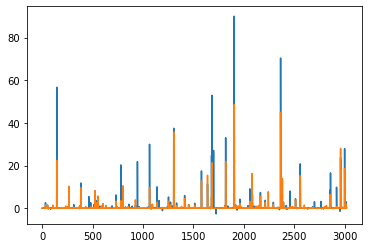

In [16]:
plt.plot(pro_nnls)
plt.plot(pro_nnls2)

In [169]:
# from pgd import pgd
# i = 0
# t1 = time()
# pro_nnls, cost_nnls = pgd(D, X[:, i], Ak=pro_nnls)#, max_iter=100000)
# t2 = time()
# print('Suma ai: ', pro_nnls.sum())
# print('Costo: ', cost_nnls)
# print(f'Tiempo: {t2-t1:.2f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Cantidad de iteraciones: 0
Tiempo: 3.27
Suma ai:  498.21110236855355
Costo:  9964.699611235874
Tiempo: 3.27


In [12]:
from nnls import nnls
i = 0
t1 = time()
pro_nnls, cost_nnls = nnls(D, X[:, i])#, max_iter=100000)
t2 = time()
print('Suma ai: ', pro_nnls.sum())
print('Costo: ', cost_nnls)
print(f'Tiempo: {t2-t1:.2f}')

Cantidad de iteraciones: 327
Tiempo: 13.01
Suma ai:  817.2898711664602
Costo:  88.43129680466946
Tiempo: 13.01


In [152]:
# x = np.cumsum([a.shape[1] for a in array_por_dia_])
# x_ = np.insert(x, 0, 0)
# x = list(map(list, list(np.vstack((x_[:-1], x)).T)))
# list(zip(x, (map(lambda x:x[0]['description'], data_submters))))

In [198]:
f = lambda A: np.linalg.norm(X[:,i]-D@A, ord=2)
f(pro_nnls)

52.690306042759595

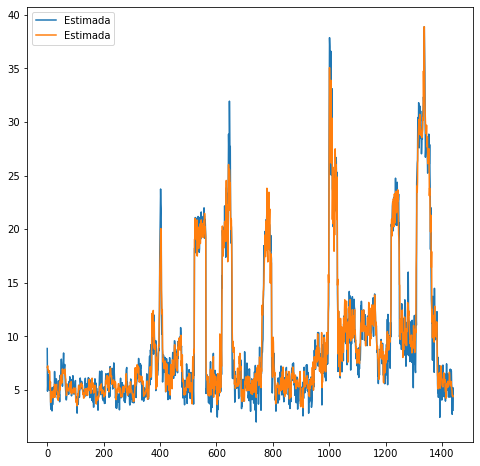

In [192]:
plt.figure(figsize=(8,8))
plt.plot((D*pro_nnls).sum(axis=1), label='Estimada')
plt.plot((D*pro_nnls2).sum(axis=1), label='Estimada')
#plt.plot(X[:, i], label='Real', alpha=0.7)
plt.legend()

In [336]:
Test.shape, 20*5

((1440, 96), 100)

In [331]:
limits = list(zip(np.cumsum([a.shape[1] for a in array_por_dia_]), (map(lambda x:x[0]['description'], data_submters))))
limits.insert(0,(0,''))
tot = (D*pro_nnls).sum(axis=1).sum()
for i in range(1, len(limits)):
    ini = limits[i-1][0]
    fin = limits[i][0]
    suma = pro_nnls[ini:fin].sum()
    porcentaje = (D[:,ini:fin]*pro_nnls[ini:fin]).sum(axis=1).sum()/tot
    print(f'{suma:.2f}\t {porcentaje*100:.1f}%\t', limits[i][1])
    

218.13	 6.7%	 Plugs and lights
0.28	 0.4%	 Plugs and lights
6.16	 5.1%	 Partial Plugs and lights
545.25	 15.9%	 Clothes Dryer
11.41	 10.4%	 Clothes Washer
506.75	 11.6%	 Plugs
13.86	 8.9%	 Dishwasher
0.00	 0.0%	 Electronics Workbench
0.00	 0.0%	 Security/Network Equipment
1.89	 5.2%	 Fridge
0.00	 0.0%	 Forced Air Furnace Fan and Thermostat
0.00	 0.0%	 Sub-Panel, Detached Building
1.72	 21.2%	 Heat Pump
53.33	 10.6%	 Instant Hot Water Unit
0.49	 0.9%	 Home Office
0.00	 0.0%	 Plugs
0.07	 1.5%	 Sub-Panel, Basement, 1 Occupant
0.00	 0.0%	 Entertainment:TV, PVR, AMP
0.00	 0.0%	 Utility Plug
0.46	 1.5%	 Wall Oven


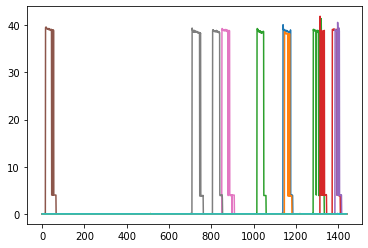

In [299]:
for i in range(10):
    plt.plot(ClothesDryer[:,i])

In [41]:
from utils import PCEC
PCEC(X[:,0], estimated)

NameError: name 'estimated' is not defined

$$f(A) = ||X - DA||_F^2$$
$$\frac{\partial f}{\partial A} (A)= -2D^T(X-DA)$$

In [22]:
D.shape

(1440, 5289)

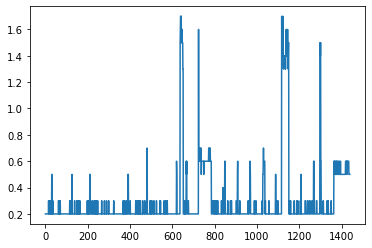

In [162]:
plt.figure()
#for i in range(HomeOffice.shape[1]):
plt.plot(HomeOffice[:,4])

In [24]:
from sklearn.decomposition import NMF

In [166]:
model = NMF(20, max_iter=100000)

In [167]:
i = 58
X = HomeOffice#np.concatenate(array_agregado_por_dia, axis=1)
W = model.fit_transform(X)
H = model.components_
# plt.figure()
# plt.plot(X[:,i:i+1])

In [168]:
W.shape

(1440, 20)

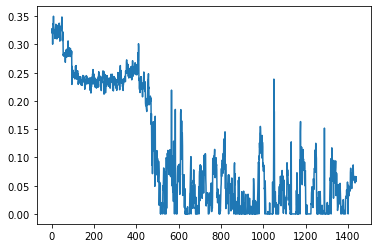

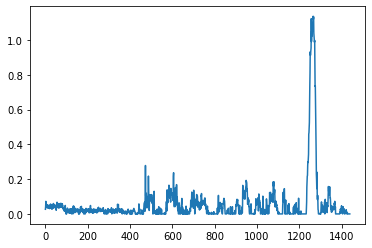

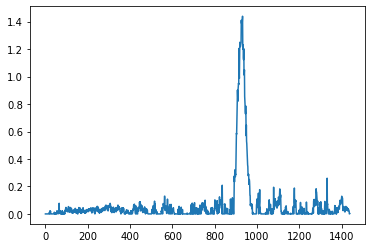

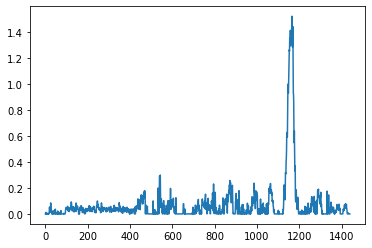

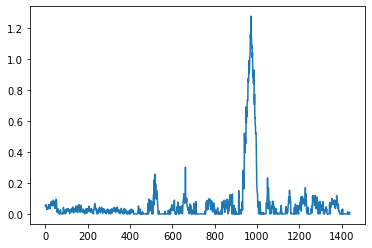

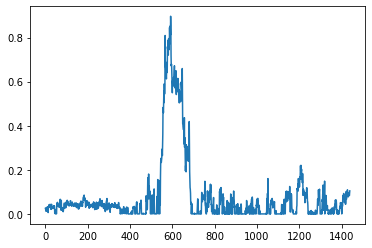

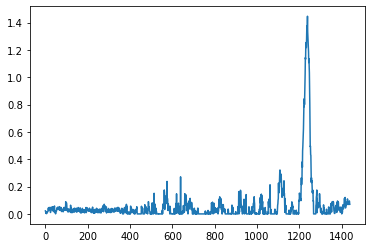

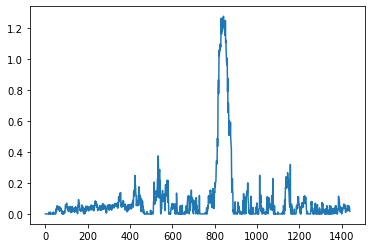

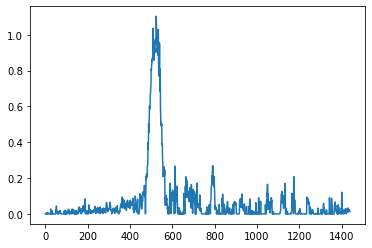

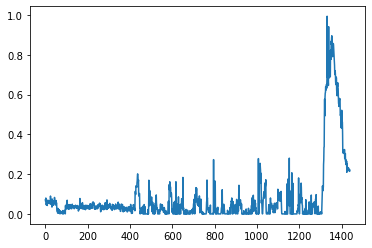

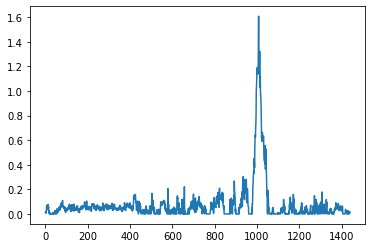

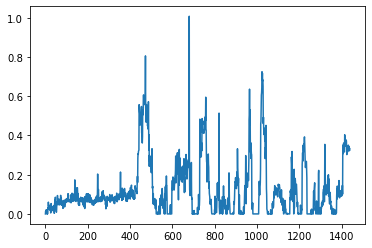

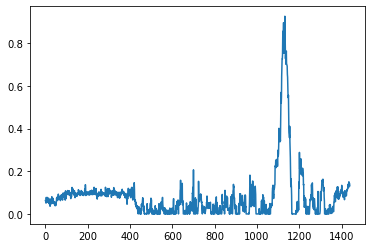

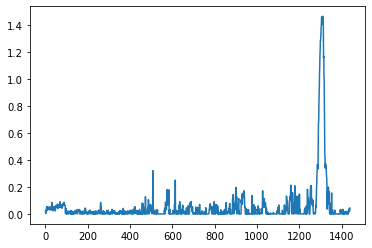

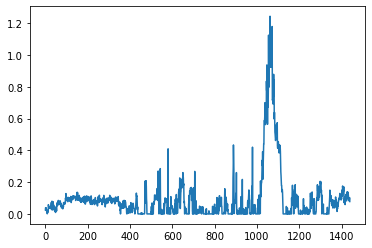

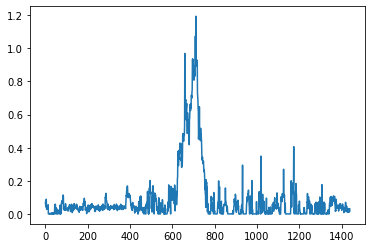

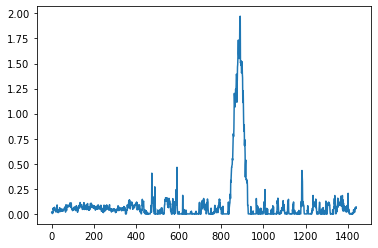

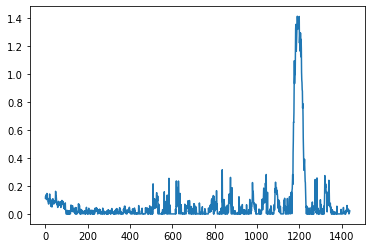

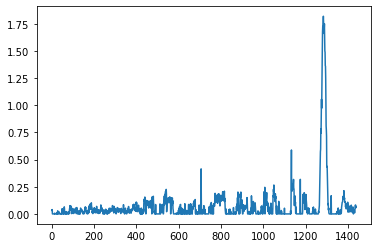

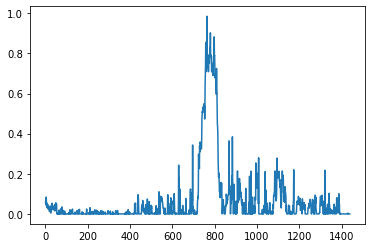

In [169]:
for i in range(W.shape[1]):
    plt.figure()
    plt.plot(W[:,i])

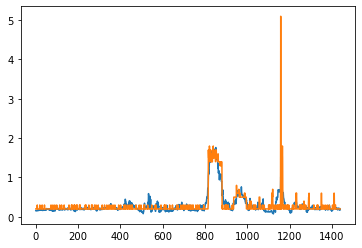

In [170]:
plt.plot((W@H)[:,2])
plt.plot(X[:,2])